## Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

---
## First, I'll compute the camera calibration using chessboard images

In [1]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
%matplotlib inline

def get_chessboard_points():
    # prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
    objp = np.zeros((6*9,3), np.float32)
    objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)
    dim = (9,6)
    
    # Arrays to store object points and image points from all the images.
    objpoints = [] # 3d points in real world space
    imgpoints = [] # 2d points in image plane.

    # Make a list of calibration images
    images = glob.glob('../camera_cal/calibration*.jpg')
    for fname in images:
        img = cv2.imread(fname)
        gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
        ret, corners = cv2.findChessboardCorners(gray, (9,6), None)
        if ret == True:
            objpoints.append(objp)
            imgpoints.append(corners)
    return objpoints, imgpoints

In [2]:
def calibrate_camera(img):
    """
    Calibrate the camera with the size respect to a particular image
    """
    objpoints, imgpoints = get_chessboard_points()
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)
    return ret, mtx, dist

### Now I calibrate camera using the objpoints and imgpoints acquired from chessboard images
This step will give me the camera matrix(mtx) and the distortion matrix(dist)

In [6]:
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)

## Second, applying a distortion correction to raw images.

In [3]:
def undistort(img, mtx, dist):
    dst = cv2.undistort(img, mtx, dist, None, mtx)
    return dst

In [4]:
straight_images = glob.glob('../test_images/straight_*.jpg')
test_images = glob.glob('../test_images/test*.jpg')

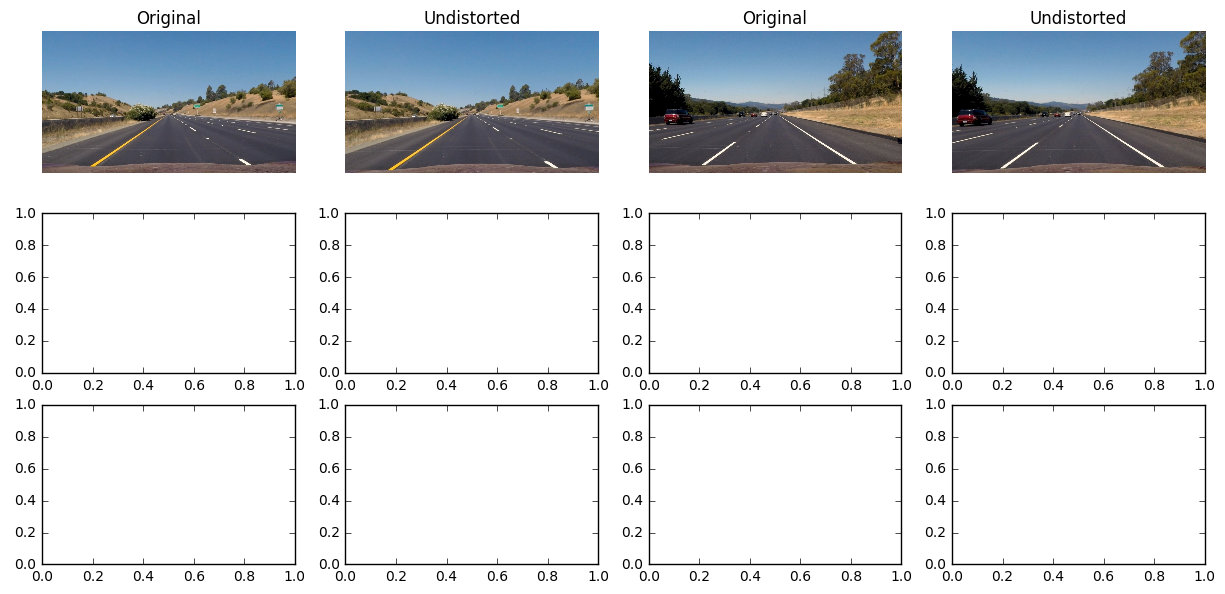

In [148]:
f, axs = plt.subplots(3, 4, figsize=(15,7))
axs = axs.ravel()
idx = 0
test_images_undist = []
for fname in straight_images:
    img = cv2.imread(fname)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    dst = cv2.undistort(img, mtx, dist, None, mtx)
    
    axs[idx].imshow(img)
    axs[idx].axis('off')
    axs[idx].set_title('Original')
    axs[idx+1].imshow(dst)
    axs[idx+1].axis('off')
    axs[idx+1].set_title('Undistorted')
    test_images_undist.append(dst)
    
    idx += 2

## Third, using color transforms, gradients, etc., to create a thresholded binary image.

In [5]:
def pipeline(img, s_thresh=(170, 255), sx_thresh=(20, 100)):
    """
    Just to combine the sobelx and S from HSL to do binary threshold of the img
    """
    img = np.copy(img)
    
    # Convert to HSV color space and separate the V channel
    hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HLS).astype(np.float)
    l_channel = hsv[:,:,1]
    s_channel = hsv[:,:,2]
    
    # Sobel x
    sobelx = cv2.Sobel(l_channel, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    
    # Threshold x gradient
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= sx_thresh[0]) & (scaled_sobel <= sx_thresh[1])] = 1
    
    # Threshold color channel
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1
    
    
    # Stack each channel to view their individual contributions in green and blue respectively
    # This returns a stack of the two binary images, whose components you can see as different colors
    color_binary = np.dstack(( np.zeros_like(sxbinary), sxbinary, s_binary))

    # Combine the two binary thresholds
    combined_binary = np.zeros_like(sxbinary)
    combined_binary[(s_binary == 1) | (sxbinary == 1)] = 1
    return combined_binary

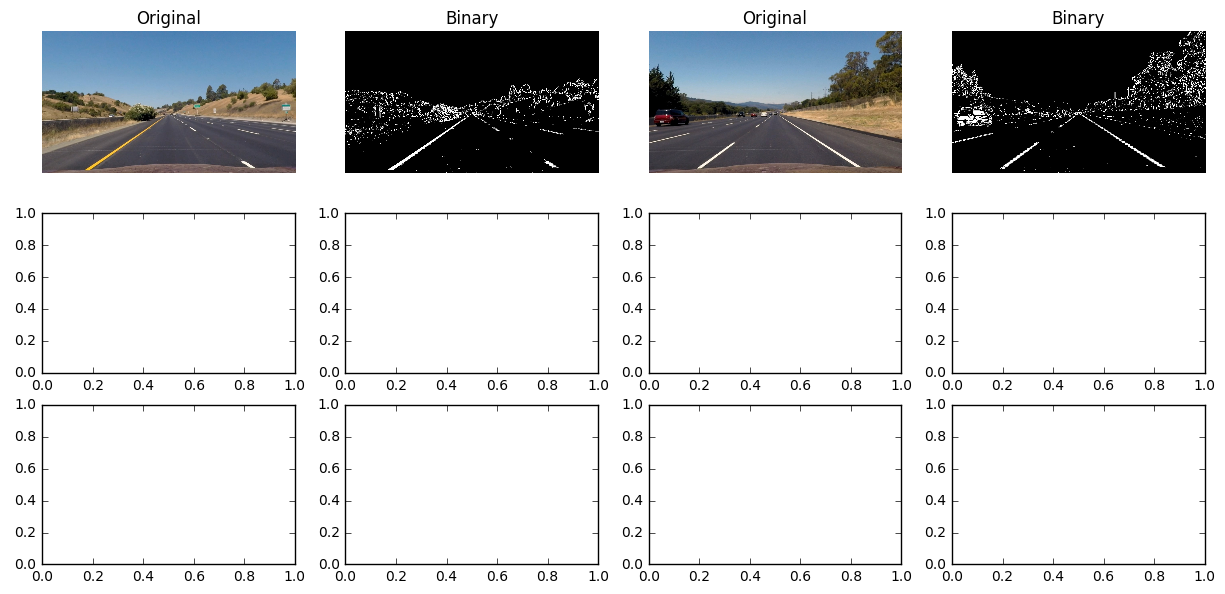

In [150]:
f, axs = plt.subplots(3, 4, figsize=(15,7))
axs = axs.ravel()
idx = 0
bin_images = []
for img in test_images_undist:
    binary_img = pipeline(img)
    
    axs[idx].imshow(img)
    axs[idx].axis('off')
    axs[idx].set_title('Original')
    axs[idx+1].imshow(binary_img, cmap='gray')
    axs[idx+1].axis('off')
    axs[idx+1].set_title('Binary')
    
    bin_images.append(binary_img)
    idx += 2

## Fourthly, Apply a perspective transform to rectify binary image ("birds-eye view").

In [6]:
def warped_bw(img):
    # Grab the image shape
    img_size = (img.shape[1], img.shape[0])
       
    # start from top-left and rotate clockwise
    src = np.float32([(585,440),(690,440),(1080,690),(215,690)])
    dst = np.float32([(0,0),(1280,0),(1080,720),(240,720)])
    
    # Given src and dst points, calculate the perspective transform matrix
    M = cv2.getPerspectiveTransform(src, dst)
    
    # Warp the image using OpenCV warpPerspective()
    warped = cv2.warpPerspective(img, M, img_size)

    # Return the resulting image and matrix
    return warped, M

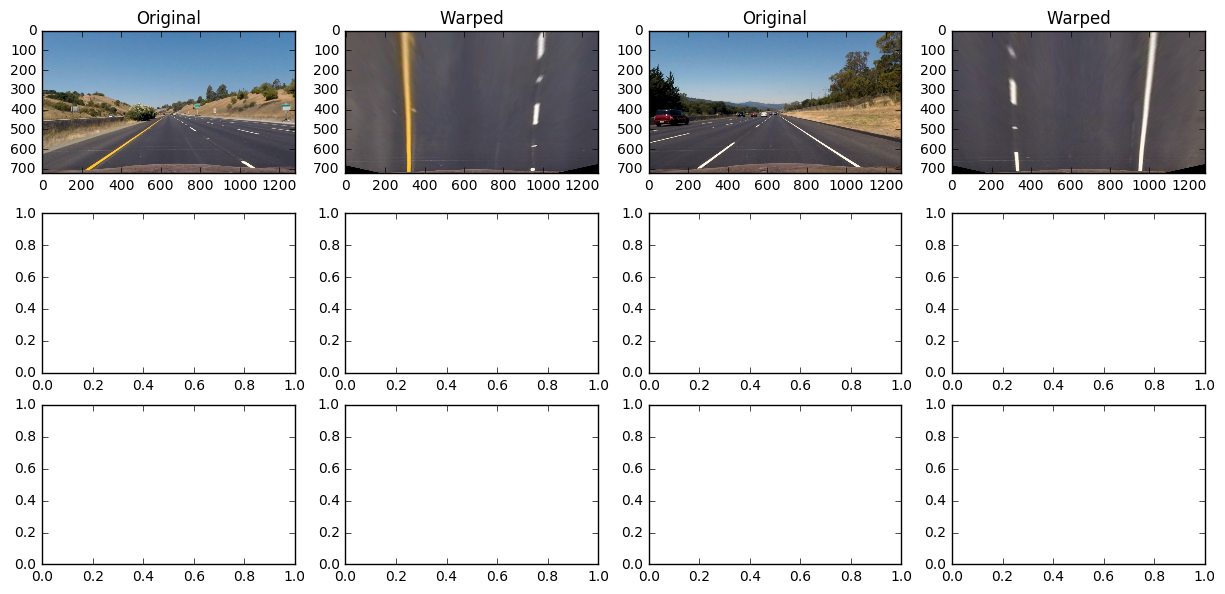

In [206]:
def warp(img, color_im):
  
    # Grab the image shape
    img_size = (img.shape[1], img.shape[0])
       
    src = np.float32([(585,460),(203,720),(1127,720),(695,460)])
    dst = np.float32([(320,0),(320,720),(960,720),(960,0)])
    
    # Given src and dst points, calculate the perspective transform matrix
    M = cv2.getPerspectiveTransform(src, dst)
    
    # Warp the image using OpenCV warpPerspective()
    warped = cv2.warpPerspective(color_im, M, img_size)

    # Return the resulting image and matrix
    return warped, M

f, axs = plt.subplots(3, 4, figsize=(15,7))
axs = axs.ravel()
idx = 0
for img in test_images_undist:
    binary_img = pipeline(img)
    binary_warped,mat = warp(binary_img,img)
    axs[idx].imshow(img, cmap='gray')
#     axs[idx].axis('off')
    axs[idx].set_title('Original')
    axs[idx+1].imshow(binary_warped, cmap='gray')
#     axs[idx+1].axis('off')
    axs[idx+1].set_title('Warped')
    
    idx += 2

# 5th, Detect lane pixels and fit to find the lane boundary.

In [231]:
img_undist = test_images_undist[0]

In [248]:
binary_img = pipeline(test_images_undist[0])
binary_warped,mat = warped_bw(binary_img)

In [16]:
def lane_detection(binary_warped):
    # Assuming you have created a warped binary image called "binary_warped"
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[int(binary_warped.shape[0]/2):,:], axis=0)
    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Choose the number of sliding windows
    nwindows = 9
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    return leftx, lefty, rightx, righty, left_fit, right_fit, left_lane_inds, right_lane_inds

In [210]:
# Assuming you have created a warped binary image called "binary_warped"
# Take a histogram of the bottom half of the image
histogram = np.sum(binary_warped[int(binary_warped.shape[0]/2):,:], axis=0)
# Create an output image to draw on and  visualize the result
out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
# Find the peak of the left and right halves of the histogram
# These will be the starting point for the left and right lines
midpoint = np.int(histogram.shape[0]/2)
leftx_base = np.argmax(histogram[:midpoint])
rightx_base = np.argmax(histogram[midpoint:]) + midpoint

# Choose the number of sliding windows
nwindows = 9
# Set height of windows
window_height = np.int(binary_warped.shape[0]/nwindows)
# Identify the x and y positions of all nonzero pixels in the image
nonzero = binary_warped.nonzero()
nonzeroy = np.array(nonzero[0])
nonzerox = np.array(nonzero[1])
# Current positions to be updated for each window
leftx_current = leftx_base
rightx_current = rightx_base
# Set the width of the windows +/- margin
margin = 100
# Set minimum number of pixels found to recenter window
minpix = 50
# Create empty lists to receive left and right lane pixel indices
left_lane_inds = []
right_lane_inds = []

# Step through the windows one by one
for window in range(nwindows):
    # Identify window boundaries in x and y (and right and left)
    win_y_low = binary_warped.shape[0] - (window+1)*window_height
    win_y_high = binary_warped.shape[0] - window*window_height
    win_xleft_low = leftx_current - margin
    win_xleft_high = leftx_current + margin
    win_xright_low = rightx_current - margin
    win_xright_high = rightx_current + margin
    # Draw the windows on the visualization image
    cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
    cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 
    # Identify the nonzero pixels in x and y within the window
    good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
    good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
    # Append these indices to the lists
    left_lane_inds.append(good_left_inds)
    right_lane_inds.append(good_right_inds)
    # If you found > minpix pixels, recenter next window on their mean position
    if len(good_left_inds) > minpix:
        leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
    if len(good_right_inds) > minpix:        
        rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

# Concatenate the arrays of indices
left_lane_inds = np.concatenate(left_lane_inds)
right_lane_inds = np.concatenate(right_lane_inds)

# Extract left and right line pixel positions
leftx = nonzerox[left_lane_inds]
lefty = nonzeroy[left_lane_inds] 
rightx = nonzerox[right_lane_inds]
righty = nonzeroy[right_lane_inds] 

# Fit a second order polynomial to each
left_fit = np.polyfit(lefty, leftx, 2)
right_fit = np.polyfit(righty, rightx, 2)

### Visualization

In [8]:
def visualize_things(binary_warped, left_fit, right_fit):
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0])
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    return ploty, left_fitx, right_fitx

(720, 0)

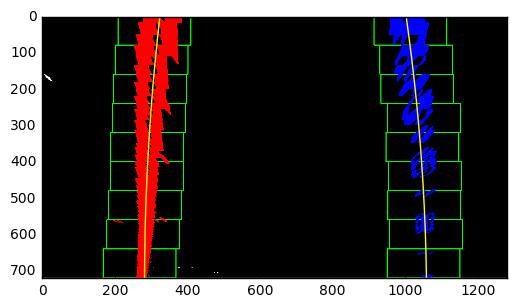

In [211]:
# Generate x and y values for plotting
ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0])
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
plt.imshow(out_img)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)

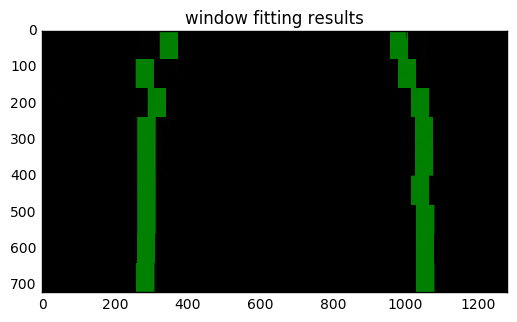

In [33]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import glob
import cv2

# Read in a thresholded image
# warped = mpimg.imread('warped_example.jpg')
warped = binary_warped
# window settings
window_width = 50 
window_height = 80 # Break image into 9 vertical layers since image height is 720
margin = 100 # How much to slide left and right for searching

def window_mask(width, height, img_ref, center,level):
    output = np.zeros_like(img_ref)
    output[int(img_ref.shape[0]-(level+1)*height):int(img_ref.shape[0]-level*height),max(0,int(center-width/2)):min(int(center+width/2),img_ref.shape[1])] = 1
    return output

def find_window_centroids(image, window_width, window_height, margin):
    
    window_centroids = [] # Store the (left,right) window centroid positions per level
    window = np.ones(window_width) # Create our window template that we will use for convolutions
    
    # First find the two starting positions for the left and right lane by using np.sum to get the vertical image slice
    # and then np.convolve the vertical image slice with the window template 
    
    # Sum quarter bottom of image to get slice, could use a different ratio
    l_sum = np.sum(warped[int(3*warped.shape[0]/4):,:int(warped.shape[1]/2)], axis=0)
    l_center = np.argmax(np.convolve(window,l_sum))-window_width/2
    r_sum = np.sum(warped[int(3*warped.shape[0]/4):,int(warped.shape[1]/2):], axis=0)
    r_center = np.argmax(np.convolve(window,r_sum))-window_width/2+int(warped.shape[1]/2)
    
    # Add what we found for the first layer
    window_centroids.append((l_center,r_center))
    
    # Go through each layer looking for max pixel locations
    for level in range(1,(int)(warped.shape[0]/window_height)):
	    # convolve the window into the vertical slice of the image
	    image_layer = np.sum(warped[int(warped.shape[0]-(level+1)*window_height):int(warped.shape[0]-level*window_height),:], axis=0)
	    conv_signal = np.convolve(window, image_layer)
	    # Find the best left centroid by using past left center as a reference
	    # Use window_width/2 as offset because convolution signal reference is at right side of window, not center of window
	    offset = window_width/2
	    l_min_index = int(max(l_center+offset-margin,0))
	    l_max_index = int(min(l_center+offset+margin,warped.shape[1]))
	    l_center = np.argmax(conv_signal[l_min_index:l_max_index])+l_min_index-offset
	    # Find the best right centroid by using past right center as a reference
	    r_min_index = int(max(r_center+offset-margin,0))
	    r_max_index = int(min(r_center+offset+margin,warped.shape[1]))
	    r_center = np.argmax(conv_signal[r_min_index:r_max_index])+r_min_index-offset
	    # Add what we found for that layer
	    window_centroids.append((l_center,r_center))

    return window_centroids

window_centroids = find_window_centroids(warped, window_width, window_height, margin)

# If we found any window centers
if len(window_centroids) > 0:

    # Points used to draw all the left and right windows
    l_points = np.zeros_like(warped)
    r_points = np.zeros_like(warped)

    # Go through each level and draw the windows 	
    for level in range(0,len(window_centroids)):
        # Window_mask is a function to draw window areas
	    l_mask = window_mask(window_width,window_height,warped,window_centroids[level][0],level)
	    r_mask = window_mask(window_width,window_height,warped,window_centroids[level][1],level)
	    # Add graphic points from window mask here to total pixels found 
	    l_points[(l_points == 255) | ((l_mask == 1) ) ] = 255
	    r_points[(r_points == 255) | ((r_mask == 1) ) ] = 255

    # Draw the results
    template = np.array(r_points+l_points,np.uint8) # add both left and right window pixels together
    zero_channel = np.zeros_like(template) # create a zero color channle 
    template = np.array(cv2.merge((zero_channel,template,zero_channel)),np.uint8) # make window pixels green
    warpage = np.array(cv2.merge((warped,warped,warped)),np.uint8) # making the original road pixels 3 color channels
    output = cv2.addWeighted(warpage, 1, template, 0.5, 0.0) # overlay the orignal road image with window results
 
# If no window centers found, just display orginal road image
else:
    output = np.array(cv2.merge((warped,warped,warped)),np.uint8)

# Display the final results
plt.imshow(output)
plt.title('window fitting results')
plt.show()


## 6th, Determine the curvature of the lane and vehicle position with respect to center

In [138]:
def get_roc(leftx, rightx):
    ploty_left = np.linspace(0, 719, num=len(leftx))
    ploty_right = np.linspace(0, 719, num=len(rightx))

    y_eval = np.max(ploty_left)
    
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension

    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(ploty_left*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(ploty_right*ym_per_pix, rightx*xm_per_pix, 2)

    # Calculate the new radii of curvature
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])       
    
    lane_width = 3.7
    center_img = 650.0*xm_per_pix
    
    y_eval = max(ploty_left)*ym_per_pix
    
    leftx_line_pos = left_fit_cr[0]*y_eval**2 + left_fit_cr[1]*y_eval + left_fit_cr[2]
    rightx_line_pos = right_fit_cr[0]*y_eval**2 + right_fit_cr[1]*y_eval + right_fit_cr[2]
            
    center_line = (rightx_line_pos-leftx_line_pos)
    off_center = center_img - center_line
    
    return left_curverad, right_curverad, off_center

In [139]:
get_roc(leftx, rightx)

(12641.992250768133, 4735.4221862975282, -0.15655292411809407)

## 7th, Warp the detected lane boundaries back onto the original image.

In [33]:
from numpy.linalg import inv

def plot_lane_boundaries(warped, ploty, left_fitx, right_fitx, mat, image):
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    Minv = inv(mat)

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (image.shape[1], image.shape[0])) 
    # Combine the result with the original image
    result = cv2.addWeighted(image, 1, newwarp, 0.3, 0)
    plt.imshow(result)
    return result

In [263]:
res = plot_lane_boundaries(warped, ploty, left_fitx, right_fitx, mat, image)

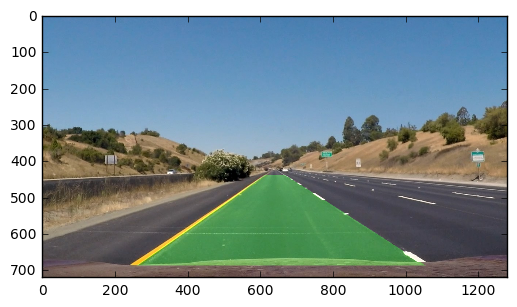

In [264]:
plt.imshow(res)

## 8th, Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

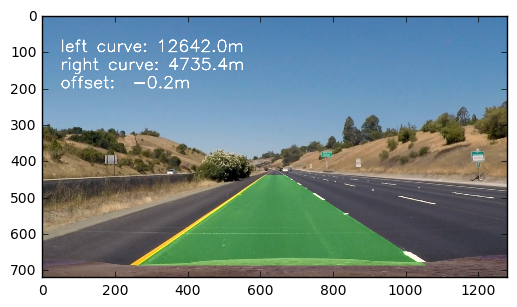

In [140]:
def plot_numerical_estimation(img):
    left_curv, right_curv, offset = get_roc(leftx, rightx)
    font = cv2.FONT_HERSHEY_SIMPLEX
    cv2.putText(img,'left curve: {:5.1f}m '.format(left_curv),(50,100), font, 1.5,(255,255,255),2,cv2.LINE_AA)
    cv2.putText(img,'right curve: {:5.1f}m '.format(right_curv),(50,150), font, 1.5,(255,255,255),2,cv2.LINE_AA)
    cv2.putText(img,'offset: {:5.1f}m '.format(offset),(50,200), font, 1.5,(255,255,255),2,cv2.LINE_AA)

a = big_pipeline(img,camera_mat,dist_mat)
plot_numerical_estimation(a)
plt.imshow(a)

# Pipeline Testing

In [73]:
straight_images = glob.glob('../test_images/straight_*.jpg')
fname = straight_images[0]
img = cv2.imread(fname)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
_, camera_mat, dist_mat = calibrate_camera(img)

In [74]:
def big_pipeline(img, camera_mat, dist_mat):
    binary_img = pipeline(img)
    binary_warped, trans_mat = warped_bw(binary_img)
    leftx, lefty, rightx, righty, left_fit, right_fit, left_lane_inds, right_lane_inds = lane_detection(binary_warped)
    ploty, left_fitx, right_fitx = visualize_things(binary_warped, left_fit, right_fit)
    res = plot_lane_boundaries(binary_warped, ploty, left_fitx, right_fitx, trans_mat, img)
    plot_numerical_estimation(res)
    
    return res

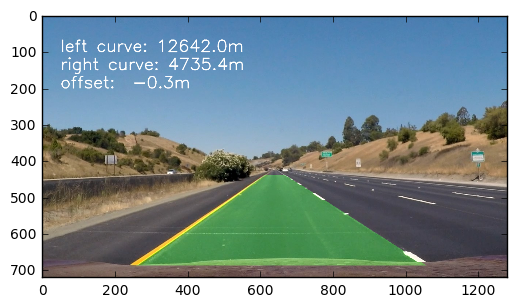

In [131]:
a = big_pipeline(img,camera_mat,dist_mat)